# 🛒 End-to-End Churn Prediction Pipeline (Olist)
**Goal:** Predict customer churn in a non-contractual e-commerce setting and identify key drivers for retention strategies.

---
### 📌 Executive Summary
This notebook executes the final production pipeline. It loads raw data, engineers features (RFM + Logistics + Satisfaction), trains a champion model, and generates an actionable **"High Risk Lead List"** for the Marketing Team.

**Key Results:**
* **Champion Model:** Logistic Regression (Selected for High Recall)
* **Primary Churn Driver:** Delivery Delays (Logistics)
* **Secondary Driver:** Review Scores (Satisfaction)

In [15]:
# Setup path to import from 'src' folder
import sys
import os
import pandas as pd

# Add the parent directory to system path to access 'src'
sys.path.append(os.path.abspath('..'))

# Import our custom modules
from src.data_prep import load_and_clean_data, generate_churn_labels, build_features, split_and_scale
from src.modeling import train_baseline_models, evaluate_models, get_model_coefficients, generate_leads
from src.visualization import set_plot_style, plot_confusion_matrix, plot_roc_curve, plot_coefficients

# Set visual style
set_plot_style()
pd.set_option('display.max_columns', None)

print("✅ Setup Complete. Modules Loaded.")

✅ Setup Complete. Modules Loaded.


### 1️⃣ Data Pipeline Execution
We load 9 raw CSV files, merge them into a single customer view, and apply "Smart Imputation" for missing values using geospatial context.

In [16]:
# 1. Load Data
# Note: We use '../data/raw/' because the notebook is inside the 'notebooks' folder
dfs = load_and_clean_data(data_path='../data/raw/')

# 2. Generate Labels (Churn Definition: >280 days inactivity)
df_targets = generate_churn_labels(dfs['orders'], dfs['customers'], threshold_days=280)

# 3. Feature Engineering (RFM + Logistics + Satisfaction)
df_features = build_features(dfs, df_targets)

# 4. Split & Scale (Ready for AI)
X_train_scaled, X_test_scaled, y_train, y_test, scaler, df_modeling = split_and_scale(
    df_features, 
    target_col='is_churn', 
    test_size=0.2
)

print(f"\nPipeline Output Shape: {X_train_scaled.shape}")
display(X_train_scaled.head(3))

Loading data from: /Users/farukmacair/Desktop/Git/olist-churn-prediction/data/raw
Generating churn labels...
Snapshot Date: 2018-08-29 | Churn Rate: 34.89%
Building feature set...
Preprocessing for model input...
Filtering: Retained 2801 repeat buyers from 93358 total customers.

Pipeline Output Shape: (2240, 6)


,frequency,avg_delivery_days,monetary_value,avg_installments,avg_review_score,has_review
69954,0.0,-0.8750,-0.858535,-0.333333,0.333333,0.0
73359,0.0,0.7500,-0.319302,-0.333333,-1.000000,0.0
42075,0.0,-0.1875,-0.097006,0.916667,0.333333,0.0


### 2️⃣ Model Training & Evaluation
We train three baseline models (Logistic Regression, Random Forest, XGBoost) handling class imbalance.
**Strategy:** We prioritize **Recall** (capturing as many churners as possible) over Precision.

In [17]:
# Train Models
models = train_baseline_models(X_train_scaled, y_train)

# Evaluate on Test Set
print("\n📊 Model Performance Comparison:")
results = evaluate_models(models, X_test_scaled, y_test)
display(results)

# Select Champion Model (Logistic Regression for Interpretability & Recall)
champion_model = models['Logistic Regression']

Training baseline models with class weights...
Fitting Logistic Regression...
Fitting Random Forest...
Fitting XGBoost...

📊 Model Performance Comparison:


,ROC-AUC,Recall,Precision,F1-Score,Accuracy
Model,,,,,
Logistic Regression,0.535610,0.541176,0.327402,0.407982,0.524064
XGBoost,0.579179,0.529412,0.361446,0.429594,0.573975
Random Forest,0.575455,0.394118,0.338384,0.364130,0.582888


### 3️⃣ Interpretability: Why are they leaving?
Using Logistic Regression coefficients, we identify the direction and magnitude of risk factors.

Figure saved to ../reports/figures/churn_drivers.png


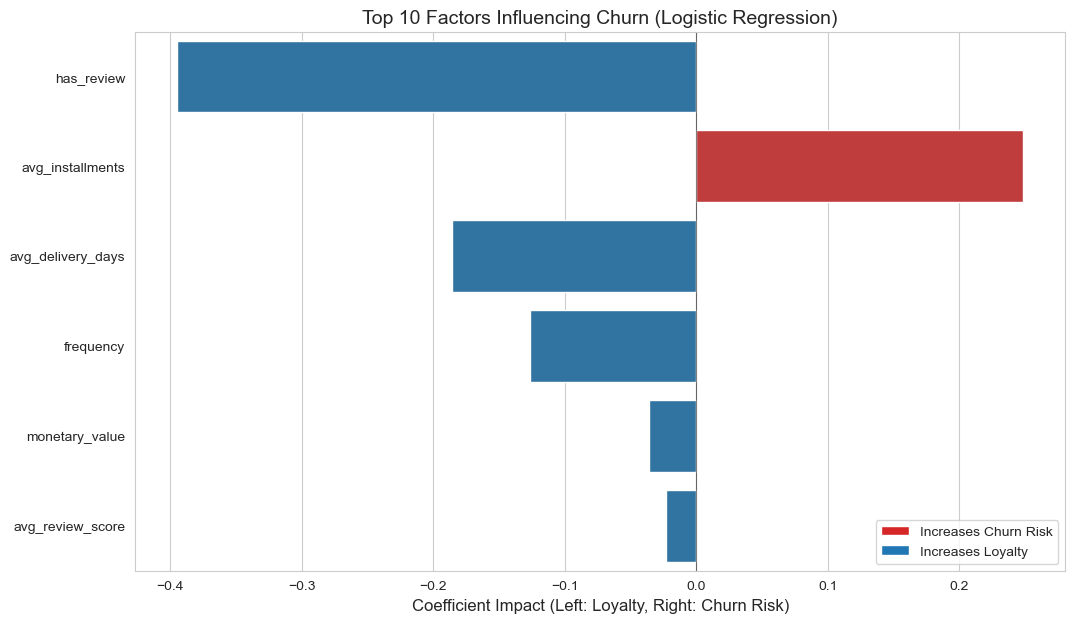

🚨 Top Risk Factors (Positive Coefficient = Increases Churn):


,Feature,Coefficient,Abs_Impact
3,avg_installments,0.248337,0.248337


In [18]:
# Extract Coefficients
feature_names = X_train_scaled.columns.tolist()
df_coef = get_model_coefficients(champion_model, feature_names)

# Visualize Drivers (Save to reports folder)
plot_coefficients(df_coef, top_n=10, save_path='../reports/figures/churn_drivers.png')

# Display Top Risk Factors
print("🚨 Top Risk Factors (Positive Coefficient = Increases Churn):")
display(df_coef[df_coef['Coefficient'] > 0].head(5))

### 4️⃣ Business Action: High Risk Lead List
We map the model's mathematical probabilities back to raw business data to create a readable list for the Marketing Team.

Max Olasılık: 0.6616
Ortalama Olasılık: 0.4968


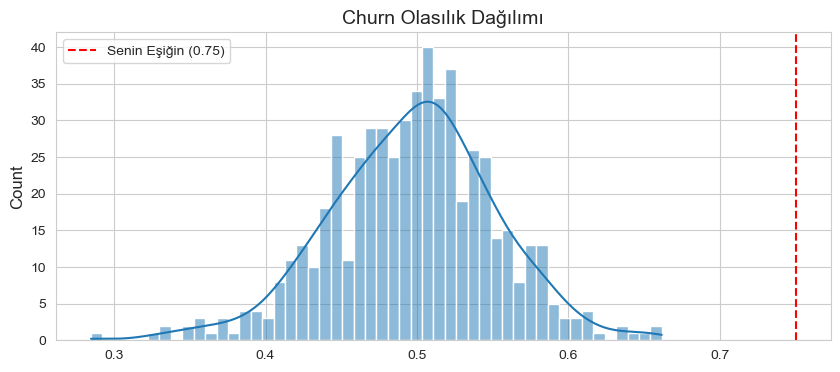

In [20]:
import matplotlib.pyplot as plt
import seaborn as sns

# Modelin Test seti için ürettiği olasılıkları alalım
y_probs = champion_model.predict_proba(X_test_scaled)[:, 1]

# İstatistiğine bakalım
print(f"Max Olasılık: {y_probs.max():.4f}")
print(f"Ortalama Olasılık: {y_probs.mean():.4f}")

# Görselleştirelim
plt.figure(figsize=(10,4))
sns.histplot(y_probs, bins=50, kde=True)
plt.axvline(x=0.75, color='r', linestyle='--', label='Senin Eşiğin (0.75)')
plt.title('Churn Olasılık Dağılımı')
plt.legend()
plt.show()

In [21]:
# Generate Leads from the Test Set (Simulating active customers)
# We map predictions back to 'df_modeling' (Raw Data) using indices
leads = generate_leads(
    model=champion_model, 
    X_scaled=X_test_scaled, 
    df_raw=df_modeling, 
    threshold=0.60
)

print(f"\n📋 ACTION REQUIRED: Identified {len(leads)} High-Risk Customers")
display(leads.head(10))

# Export for CRM
leads.to_csv('../reports/high_risk_customers.csv')
print("✅ Exported list to 'reports/high_risk_customers.csv'")


📋 ACTION REQUIRED: Identified 14 High-Risk Customers


,churn_probability,frequency,monetary_value,avg_delivery_days,avg_review_score
18631,0.661645,2,481.25,10.0,5.0
41775,0.655558,2,365.77,8.0,5.0
30955,0.648685,2,269.18,6.0,5.0
84358,0.644998,2,313.79,5.0,3.0
81395,0.638649,2,297.68,5.0,5.0
75315,0.636060,2,635.32,3.0,5.0
9293,0.617809,2,277.25,9.0,5.0
55081,0.611870,2,239.94,5.0,5.0
90494,0.611786,2,630.37,7.5,5.0
35273,0.611407,2,207.61,8.0,5.0


✅ Exported list to 'reports/high_risk_customers.csv'
